# SARIMA model for predicting the use of charging stations

This notebook describes the development and analysis of an SARIMA model for predicting the hourly utilization of charging stations.

## Data preparation

The data is loaded from a CSV file and divided into training, validation, and test data sets. The relevant input and target variables are:

- **Input variables:** `['hour_sin', 'hour_cos', 'is_holiday', 'is_weekend', 'is_vacation']`
- **Target variables:** `['activeSessions_site_1', 'activeSessions_site_2']`

The data is then split into three sets:

- **Training set**: 70% of the data is used to train the model.
- **Validation set**: 20% is used for tuning and evaluating the model during development.
- **Test set**: 10% is kept aside for final evaluation after model training.


In [1]:
import os
os.chdir(r'/')
new_directory = r"C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer"
os.chdir(new_directory)
print(os.getcwd())  # Verify the new working directory

C:\Users\tobia\Documents\GitHub\AnalyticsandApplications\AAEnergizer


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


# --- Load the data ---
df = pd.read_csv("data/processed/hourly_avg_power_cut.csv", index_col='hour', parse_dates=['hour'])
# Set 'hour' column as index

# Only use target variables
target_columns = ['activeSessions_site_1', 'activeSessions_site_2']
exog_columns = ['is_holiday', 'is_weekend']
data = df[target_columns + exog_columns]


# --- Split the data into train, validation, and test sets ---
train_size = int(len(data) * 0.7)  # 70% of the data for training
val_size = int(len(data) * 0.2)  # 20% of the data for validation

train_data = data.iloc[:train_size]  # Training data
val_data = data.iloc[train_size:train_size + val_size]  # Validation data
test_data = data.iloc[train_size + val_size:]  # Test data

print(test_data)

# Save the test data for later use
test_data.to_csv("data/processed/test_dataset_shiftedARIMA.csv")

                     activeSessions_site_1  activeSessions_site_2  is_holiday  \
hour                                                                            
2020-01-06 17:00:00                     52                     15         0.0   
2020-01-06 18:00:00                     52                     19         0.0   
2020-01-06 19:00:00                     56                     20         0.0   
2020-01-06 20:00:00                     54                     21         0.0   
2020-01-06 21:00:00                     54                     21         0.0   
...                                    ...                    ...         ...   
2020-02-29 20:00:00                      4                      3         0.0   
2020-02-29 21:00:00                      4                      4         0.0   
2020-02-29 22:00:00                      5                      3         0.0   
2020-02-29 23:00:00                      5                      4         0.0   
2020-03-01 00:00:00         

Next, the stationarity of the target variables is tested using statistical tests. Since SARIMA models require stationary data, we perform the following steps for each target variable:

1. **ADF Test**: The Augmented Dickey-Fuller (ADF) test is used to check if the time series is stationary. If the p-value is greater than 0.05, the series is considered non-stationary.

2. **KPSS Test**: The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is applied as an additional check. A p-value greater than 0.05 suggests that the series is stationary.

3. **Differencing**: If the series is found to be non-stationary by both tests, differencing is applied up to a maximum of 5 times to make the series stationary. After each differencing, the tests are re-applied to confirm if the series has become stationary.

Stationarity test for activeSessions_site_1:
ADF-Test: p-value = 0.0000
ADF: Stationary
------


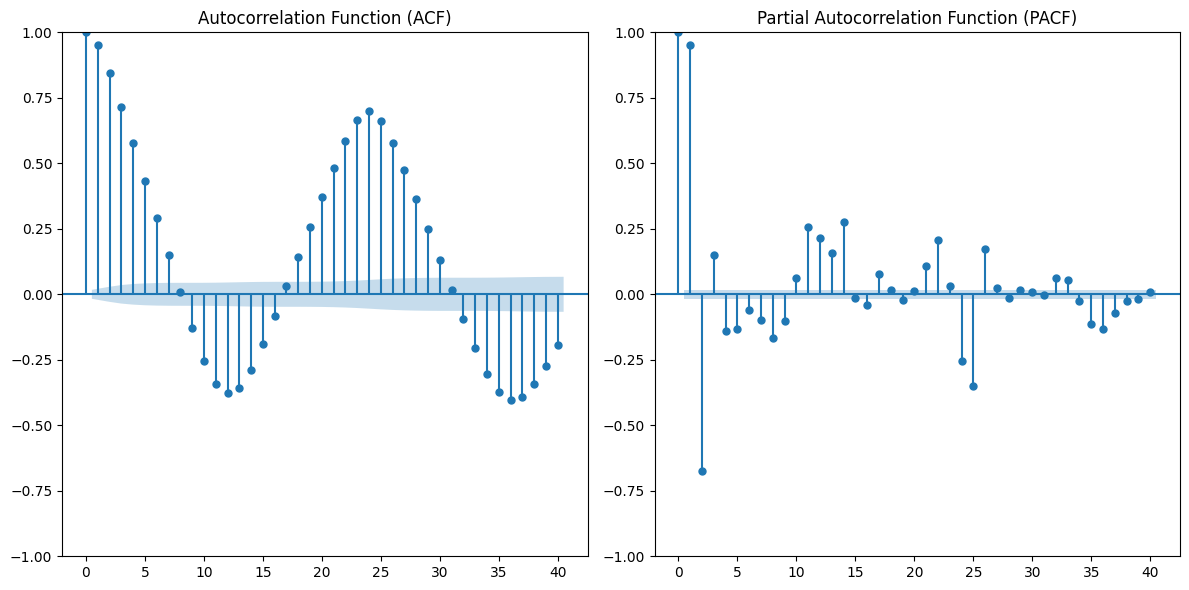

Stationarity test for activeSessions_site_2:
ADF-Test: p-value = 0.0000
ADF: Stationary
------


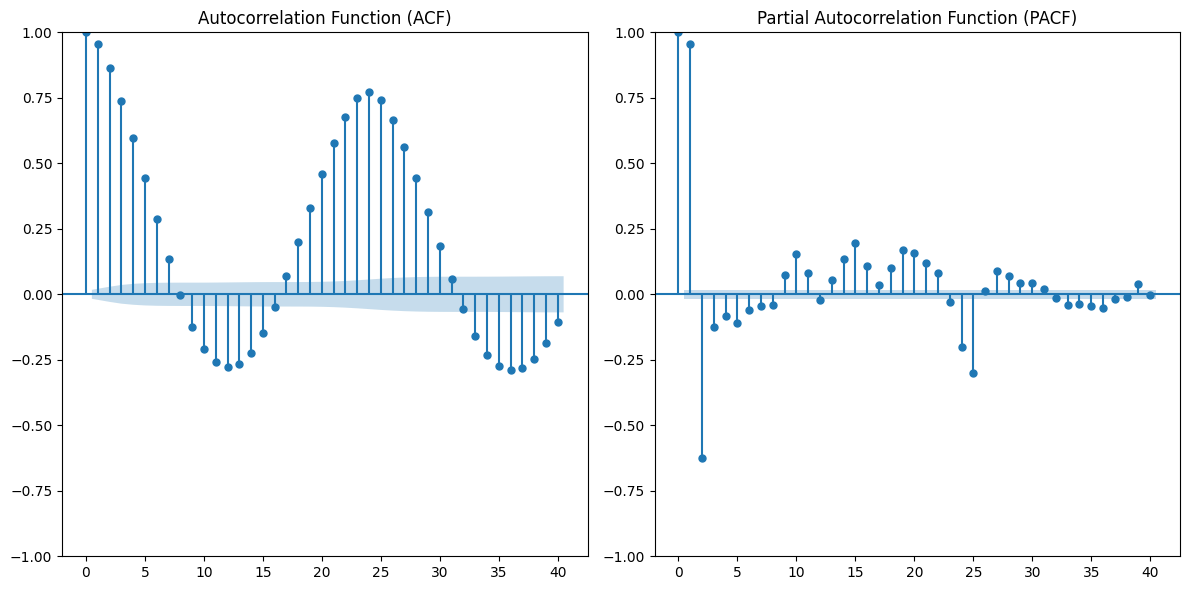

In [6]:
def check_stationarity(series, alpha=0.05, max_diff=5):
    diff_count = 0
    stationarity_changed = False  # Flag for stationarity change after differencing

    while diff_count < max_diff:
        # ADF-Test
        adf_result = adfuller(series)
        adf_pvalue = adf_result[1]
        print(f"ADF-Test: p-value = {adf_pvalue:.4f}")
        if adf_pvalue < alpha:
            print("ADF: Stationary")
            break
        else:
            print("ADF: Not stationary")

        # KPSS-Test
        kpss_result = kpss(series, nlags="auto")
        kpss_pvalue = kpss_result[1]
        print(f"KPSS-Test: p-value = {kpss_pvalue:.4f}")
        if kpss_pvalue > alpha:
            print("KPSS: Stationary")
            break
        else:
            print("KPSS: Not stationary")

        # Differencing if not stationary
        series = series.diff().dropna()  # Remove NaN values after differencing
        diff_count += 1
        stationarity_changed = True
        # Plot the differenced series to visually check for stationarity
        print(f"--- Differencing #{diff_count} ---")
        plot_series(series, f"Series after Differencing #{diff_count}")

    if diff_count == max_diff:
        print("Max differencing reached.")

    return stationarity_changed


def plot_series(series, title="Time Series"):
    plt.figure(figsize=(10, 6))
    plt.plot(series)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')

def plot_acf_pacf(series, lags=40):
    plt.figure(figsize=(12, 6))

    # Plot ACF (determining q)
    plt.subplot(121)
    plot_acf(series, lags=lags, ax=plt.gca(), title="Autocorrelation Function (ACF)")

    # Plot PACF (determining p)
    plt.subplot(122)
    plot_pacf(series, lags=lags, ax=plt.gca(), title="Partial Autocorrelation Function (PACF)")
    plt.tight_layout()
    plt.show()


# Check stationarity and plot ACF/PACF for each target variable
for col in target_columns:
    print(f"Stationarity test for {col}:")

    # Copy original series for differencing in the loop
    series_copy = data[col].copy()

    # Test stationarity
    stationarity_changed = check_stationarity(series_copy)
    print("------")

    # If differenced, check stationarity again
    if stationarity_changed:
        print(f"Stationarity test after differencing for {col}:")
        check_stationarity(series_copy)
        print("------")

    # Plot ACF and PACF after stationarity check and differencing
    plot_acf_pacf(series_copy)


plt.show()


## Autoregressive ($p$, $P$) and Moving Average ($q$, $Q$) Orders:

From the **ACF** plot, we observe slow decay with significant peaks at the first two lags, suggesting that **$q$** could be **1 or 2**, indicating the presence of seasonal patterns.

Meanwhile, the **PACF** plot shows a sharp drop after Lag 1, indicating that **$p$** might be **2 or 3**, which typically indicates the autoregressive structure of the time series.

These insights help guide our choice of **$p$** and **$q$** for the model.

Given the presence of seasonal patterns indicated by the ACF plot, we opted for a **SARIMA** model instead of a standard ARIMA model. The **SARIMA** model allows us to incorporate
seasonal components improving the forecast accuracy for time series with periodic behavior.


## Cross-Validation for SARIMA Model

The following code performs cross-validation for the SARIMA model using a rolling-window approach:

- **Rolling Window**: The dataset is split into training and testing sets, where the training set has a fixed window size, and the testing set corresponds to the forecast horizon.

- **Model Fitting**: For each window, the SARIMA model is fitted to the training data using the specified parameters, and forecasts are made for the test data.

- **Forecasting**: The `SARIMAX` model is used to generate forecasts, and negative values are avoided by applying `np.maximum` to ensure all predictions are non-negative.

- **Error Calculation**: Prediction errors are calculated by subtracting the actual values from the predicted ones.

- **Plotting**: A plot is generated to visually compare actual values, predictions, and prediction errors over time.

This method allows for an evaluation of the model's performance across different time windows.


In [13]:
def cross_validate_sarima(sarima_model, data, target_col, exog_cols, window_size, forecast_horizon):
    if data.index.freq is None:
        data = data.asfreq('h')

    actual = []
    predictions = []
    time_points = []

    # Rolling window cross-validation + define training and testing sets based on the window
    for start in range(0, len(data) - window_size - forecast_horizon, forecast_horizon):
        train = data[target_col].iloc[start:start + window_size]
        test = data[target_col].iloc[start + window_size:start + window_size + forecast_horizon]
        exog_train = data[exog_cols].iloc[start:start + window_size]
        exog_test = data[exog_cols].iloc[start + window_size:start + window_size + forecast_horizon]
        test_time = data.index[start + window_size:start + window_size + forecast_horizon]

        # Initialize and fit the SARIMA model
        model = SARIMAX(train,
                        order=(sarima_model[0], sarima_model[1], sarima_model[2]),
                        seasonal_order=(sarima_model[3], sarima_model[4], sarima_model[5], sarima_model[6]),
                        exog=exog_train)

        # Fit model and forecast
        results = model.fit(disp=False, maxiter=200)
        forecast = results.forecast(steps=forecast_horizon, exog=exog_test)

        # Prevent negative values
        forecast = np.maximum(forecast, 0)

        predictions.extend(forecast)
        actual.extend(test)
        time_points.extend(test_time)

    actual = np.array(actual)
    errors = predictions - actual

    # Plot actual vs predictions
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, actual, label='Actual', color='blue')
    plt.plot(time_points, predictions, label='Predictions', color='red')
    plt.title("SARIMA: Actual vs Predictions")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot errors separately
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, errors, label='Error', color='green')
    plt.title("SARIMA: Prediction Errors")
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.show()

    return actual, predictions

# SARIMA Model Analysis

In the following section, the SARIMA model plots are generated to visualize the stationarity and model fit. The choice of model parameters is based on statistical tests and autocorrelation patterns:

## Differencing Parameters ($d$, $D$):

The stationarity of the data was assessed using the ADF and KPSS tests. While the series was already stationary ($d = 0$), better forecasting results were achieved with seasonal differencing ($D = 1$), likely due to residual seasonality in the data.

## Autoregressive ($p$, $P$) and Moving Average ($q$, $Q$) Orders:

- The PACF plot shows a strong drop after Lag 1, suggesting a first-order autoregressive component ($P = 1$).
- The ACF plot exhibits slow decay with significant peaks at seasonal lags, indicating a seasonal moving average term ($Q = 1$).

Upon further examination of the ACF and PACF plots:

- The PACF suggests that the optimal value for $p$ lies between 2 and 3, as the partial autocorrelations drop significantly after these lags.
- The ACF indicates that $q$ could be 1 or 2, as the autocorrelations decay slowly and show significant peaks at lags 1 and 2.

Thus, the best values for $p$ and $q$ were found to be $p = 3$ and $q = 1$ based on cross-validation results.

## Seasonal Period ($s$):

Since the time series exhibits strong seasonal patterns on a 24-hour cycle (e.g., daily seasonality), a seasonal period of $s = 24$ hours is used to model daily fluctuations.

With these parameter choices, the SARIMA model aims to capture both short-term dependencies and long-term seasonal fluctuations, optimizing prediction accuracy for a 24-hour forecasting horizon.


Cross-Validation for activeSessions_site_1:


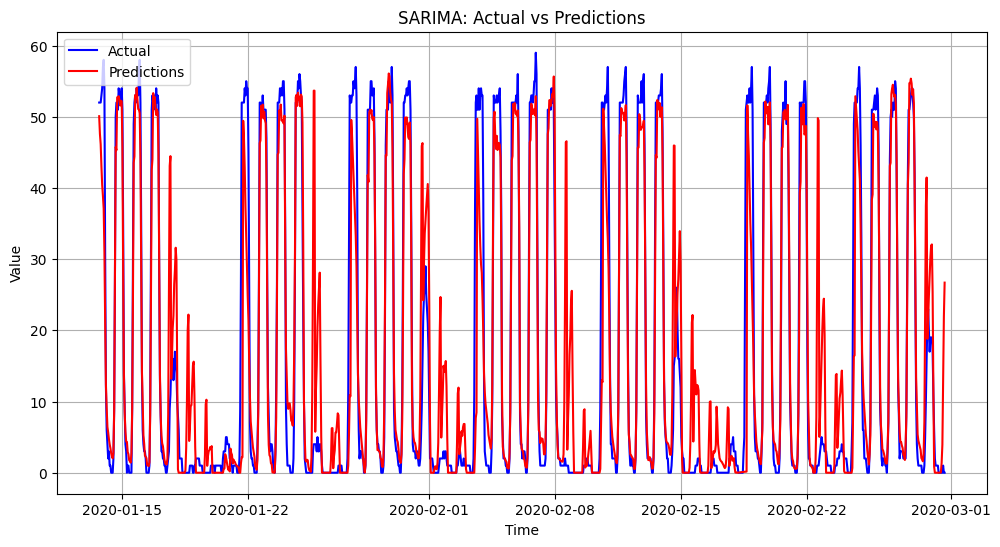

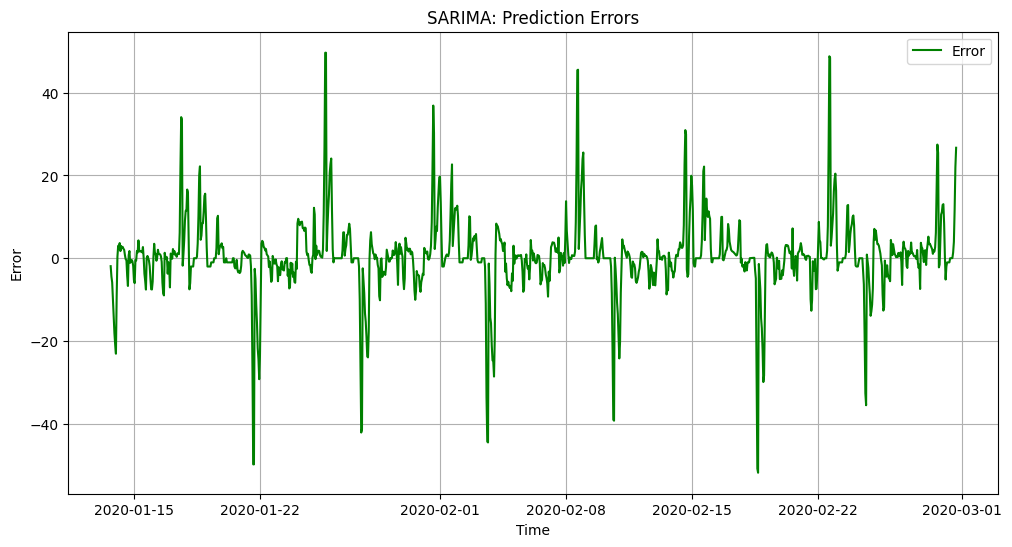

MSE for SARIMA: 86.67639595022817
Cross-Validation for activeSessions_site_2:


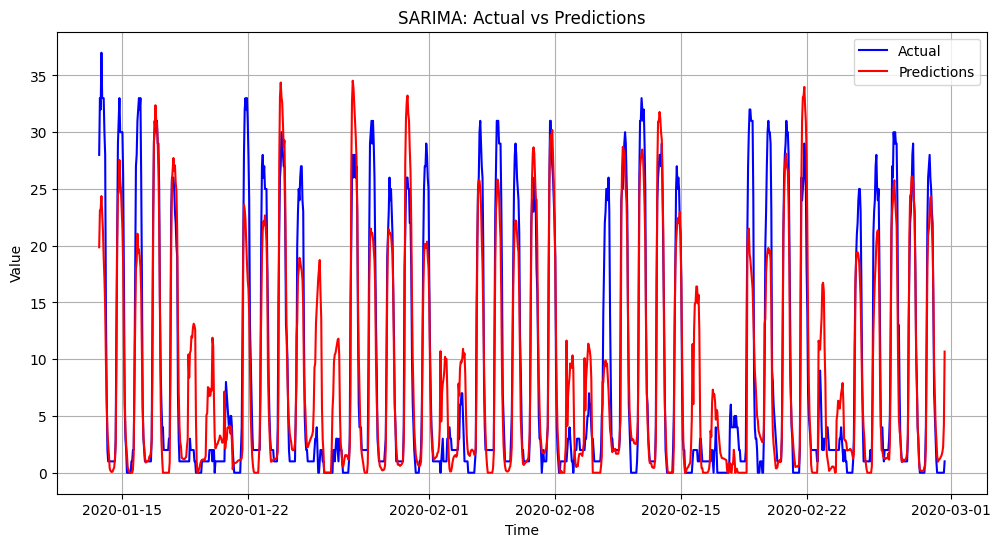

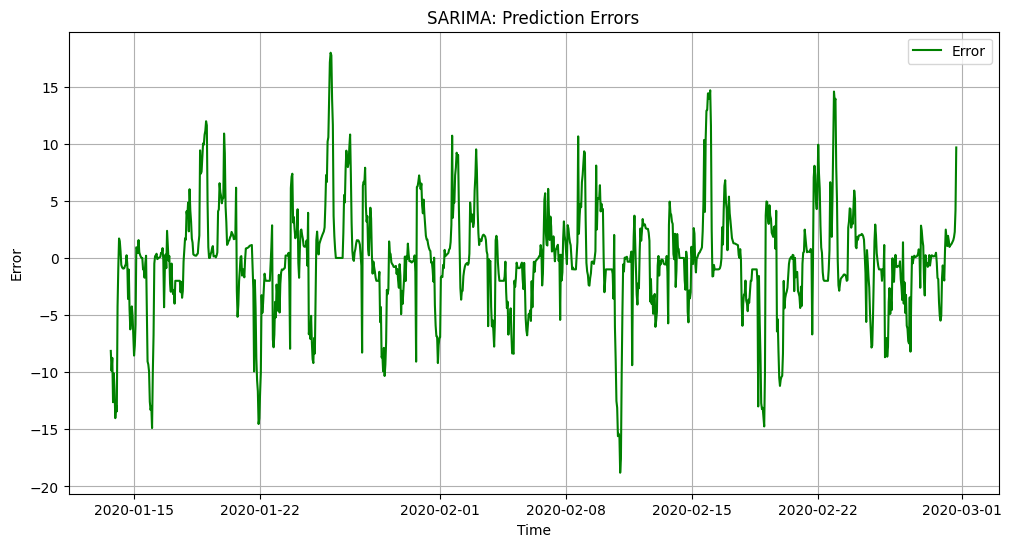

MSE for SARIMA: 21.793160652976177


In [14]:
# Cross-Validation for 'activeSessions_site_1' with SARIMA
print("Cross-Validation for activeSessions_site_1:")
actual, predictions =cross_validate_sarima((3, 0, 1, 1, 1, 1, 24), test_data, 'activeSessions_site_1',exog_columns, window_size=168, forecast_horizon=24)
mse = np.mean((actual - predictions) ** 2)
print(f"MSE for SARIMA: {mse}")
# Cross-Validation for 'activeSessions_site_2' with SARIMA
print("Cross-Validation for activeSessions_site_2:")
actual, predictions =cross_validate_sarima((3, 0, 1, 1, 1, 1, 24), test_data, 'activeSessions_site_2',exog_columns, window_size=168, forecast_horizon=24)
mse = np.mean((actual - predictions) ** 2)
print(f"MSE for SARIMA: {mse}")